In [1]:
!pip install koolbox scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 71.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


# Imports and configs

In [2]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from scipy.stats import pearsonr as pr
from xgboost import XGBRegressor
from sklearn.base import clone
from koolbox import Trainer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import joblib
import glob
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/drw-crypto-market-prediction/train.parquet"
    test_path = "/kaggle/input/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "/kaggle/input/drw-crypto-market-prediction/sample_submission.csv"

    target = "label"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 500

# Data loading and preprocessing

In [4]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [5]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test.drop(CFG.target, axis=1)

Reducing memory usage for: train
--- Memory usage before: 3594.93 MB
--- Memory usage after: 961.92 MB
--- Decreased memory usage by 73.2%

Reducing memory usage for: test
--- Memory usage before: 3678.76 MB
--- Memory usage after: 984.36 MB
--- Decreased memory usage by 73.2%



In [6]:
features = [
    # https://www.kaggle.com/code/sadettinamilverdil/yat-r-m-tavsiyesi-de-ildir
    "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"
]

X = X[features]
X_test = X_test[features]

# Training base models

In [7]:
def pearsonr(y_true, y_pred):
    return pr(y_true, y_pred)[0]

In [8]:
lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5625888953382505,
    "learning_rate": 0.029312951475451557,
    "min_child_samples": 63,
    "min_child_weight": 0.11456572852335424,
    "n_estimators": 126,
    "n_jobs": -1,
    "num_leaves": 37,
    "random_state": 42,
    "reg_alpha": 85.2476527854083,
    "reg_lambda": 99.38305361388907,
    "subsample": 0.450669817684892,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.34695458228489784,
    "learning_rate": 0.031023014900595287,
    "min_child_samples": 30,
    "min_child_weight": 0.4727729225033618,
    "n_estimators": 220,
    "n_jobs": -1,
    "num_leaves": 58,
    "random_state": 42,
    "reg_alpha": 38.665994901468224,
    "reg_lambda": 92.76991677464294,
    "subsample": 0.4810891284493255,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbosity": 0
}

In [9]:
fold_scores = {}
overall_scores = {}

oof_preds = {}
test_preds = {}

## LightGBM (gbdt)

In [10]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

lgbm_trainer.fit(X, y)

fold_scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
overall_scores["LightGBM (gbdt)"] = [pearsonr(lgbm_trainer.oof_preds, y)]
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

--- Fold 0 - pearsonr: 0.119944 - Time: 3.66 s
--- Fold 1 - pearsonr: 0.101273 - Time: 2.77 s
--- Fold 2 - pearsonr: 0.023888 - Time: 2.65 s
--- Fold 3 - pearsonr: 0.159401 - Time: 2.78 s
--- Fold 4 - pearsonr: 0.086810 - Time: 2.52 s

------ Overall pearsonr: 0.088687 - Mean pearsonr: 0.098263 ± 0.044452 - Time: 14.96 s


## LightGBM (goss)

In [11]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

lgbm_goss_trainer.fit(X, y)

fold_scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
overall_scores["LightGBM (goss)"] = [pearsonr(lgbm_goss_trainer.oof_preds, y)]
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

--- Fold 0 - pearsonr: 0.125020 - Time: 4.84 s
--- Fold 1 - pearsonr: 0.101415 - Time: 4.88 s
--- Fold 2 - pearsonr: 0.034181 - Time: 5.72 s
--- Fold 3 - pearsonr: 0.156489 - Time: 4.80 s
--- Fold 4 - pearsonr: 0.093788 - Time: 4.87 s

------ Overall pearsonr: 0.096503 - Mean pearsonr: 0.102178 ± 0.040413 - Time: 25.68 s


## XGBoost

In [12]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

xgb_trainer.fit(X, y)

fold_scores["XGBoost"] = xgb_trainer.fold_scores
overall_scores["XGBoost"] = [pearsonr(xgb_trainer.oof_preds, y)]
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

--- Fold 0 - pearsonr: 0.186980 - Time: 17.17 s
--- Fold 1 - pearsonr: 0.126919 - Time: 16.36 s
--- Fold 2 - pearsonr: 0.085247 - Time: 17.68 s
--- Fold 3 - pearsonr: 0.162445 - Time: 17.37 s
--- Fold 4 - pearsonr: 0.137543 - Time: 16.20 s

------ Overall pearsonr: 0.137687 - Mean pearsonr: 0.139827 ± 0.034310 - Time: 85.37 s


## AutoGluon

In [13]:
oof_preds_files = glob.glob(f'/kaggle/input/drw-crypto-market-prediction-autogluon/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/drw-crypto-market-prediction-autogluon/*_test_preds_*.pkl')

ag_oof_preds = joblib.load(oof_preds_files[0])
ag_test_preds = joblib.load(test_preds_files[0])

ag_score = [pearsonr(ag_oof_preds, y)]

ag_scores = []
split = KFold(n_splits=CFG.n_folds).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = pearsonr(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], overall_scores["AutoGluon"], fold_scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_score, ag_scores

# Ensembling with Ridge

In [14]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [15]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [16]:
joblib.dump(X, "oof_preds.pkl")
joblib.dump(X_test, "test_preds.pkl")

['test_preds.pkl']

In [17]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 100),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "positive": trial.suggest_categorical("positive", [True, False])
    }

    trainer = Trainer(
        Ridge(**params),
        cv=KFold(n_splits=5, shuffle=False),
        metric=pearsonr,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return pearsonr(trainer.oof_preds, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True, n_startup_trials=CFG.n_optuna_trials // 10)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"],
        "fit_intercept": best_params["fit_intercept"],
        "positive": best_params["positive"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-06-07 07:29:20,197] A new study created in memory with name: no-name-1b964b42-8a69-491b-bb71-d826cf2c8865
[I 2025-06-07 07:29:22,808] Trial 0 finished with value: 0.16666320696255205 and parameters: {'alpha': 58.55129990713325, 'tol': 0.006489926122192889, 'fit_intercept': False, 'positive': False}. Best is trial 0 with value: 0.16666320696255205.
[I 2025-06-07 07:29:23,130] Trial 1 finished with value: 0.1579779232646187 and parameters: {'alpha': 8.45059860781564, 'tol': 0.002571514544033319, 'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 0.16666320696255205.
[I 2025-06-07 07:29:23,416] Trial 2 finished with value: 0.13626339963732073 and parameters: {'alpha': 58.586589051361635, 'tol': 0.00913872888100316, 'fit_intercept': True, 'positive': True}. Best is trial 0 with value: 0.16666320696255205.
[I 2025-06-07 07:29:23,424] Trial 3 finished with value: 0.14807715055496556 and parameters: {'alpha': 27.515834216297065, 'tol': 0.003925061060633491, 'fit_in

In [18]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=KFold(n_splits=5, shuffle=False),
    metric=pearsonr,
    task="regression",
    metric_precision=6
)

ridge_trainer.fit(X, y)

fold_scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
overall_scores["Ridge (ensemble)"] = [pearsonr(ridge_trainer.oof_preds, y)]
ridge_test_preds = ridge_trainer.predict(X_test)

Training Ridge

--- Fold 0 - pearsonr: 0.212626 - Time: 0.03 s
--- Fold 1 - pearsonr: 0.153464 - Time: 0.03 s
--- Fold 2 - pearsonr: 0.138603 - Time: 0.03 s
--- Fold 3 - pearsonr: 0.182487 - Time: 0.03 s
--- Fold 4 - pearsonr: 0.155381 - Time: 0.03 s

------ Overall pearsonr: 0.166675 - Mean pearsonr: 0.168512 ± 0.026210 - Time: 0.79 s


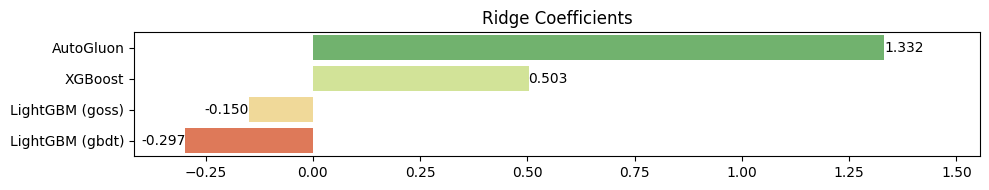

In [19]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [20]:
sub = pd.read_csv(CFG.sample_sub_path)
sub["prediction"] = ridge_test_preds
sub.to_csv(f"sub_ridge_{overall_scores['Ridge (ensemble)'][0]:.6f}.csv", index=False)
sub.head()

,ID,prediction
0,1,0.149773
1,2,-0.060305
2,3,0.211277
3,4,0.017164
4,5,0.216881


# Results

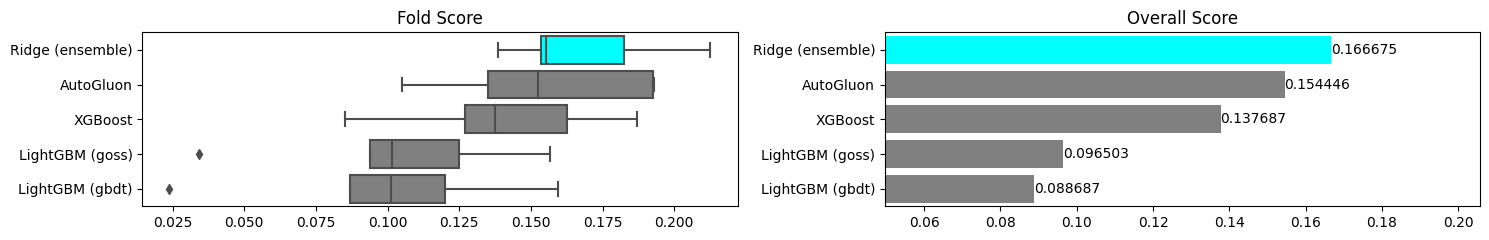

In [21]:
fold_scores = pd.DataFrame(fold_scores)
overall_scores = pd.DataFrame(overall_scores).transpose().sort_values(by=0, ascending=False)
order = overall_scores.index.tolist()

min_score = overall_scores.values.flatten().min()
max_score = overall_scores.values.flatten().max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, fold_scores.shape[1] * 0.5))

boxplot = sns.boxplot(data=fold_scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold Score")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores.values.flatten(), y=overall_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Overall Score")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(overall_scores.values.flatten(), overall_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()